<a href="https://colab.research.google.com/github/Kolawole-a2/Kola_Projects/blob/main/Assisment_5_with_errors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving creditcard.csv to creditcard.csv
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206

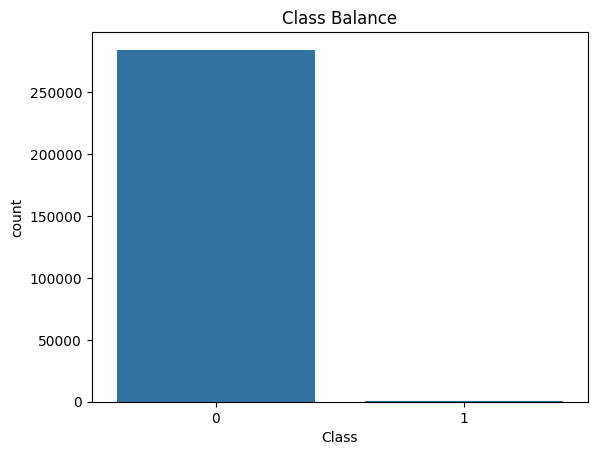

Class
0    0.998273
1    0.001727
Name: proportion, dtype: float64


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan]
  warnings.warn(


Best Isolation Forest Parameters: {'contamination': 0.01, 'max_samples': 'auto', 'n_estimators': 100, 'random_state': 42}


KeyboardInterrupt: 

In [ ]:
# 1. Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.decomposition import PCA

# 2. Load the data manually
from google.colab import files
uploaded = files.upload()

# After uploading manually, load the CSV
df = pd.read_csv(next(iter(uploaded)))

# 3. EDA - Exploratory Data Analysis
print(df.head())
print(df.describe())
print(df.info())

# Visualizing class balance
sns.countplot(x='Class', data=df)
plt.title('Class Balance')
plt.show()

# Check Class Distribution
print(df['Class'].value_counts(normalize=True))  # % of fraud vs non-fraud

# 4. Train-Test Split (keep class balance)
X = df.drop('Class', axis=1)
y = df['Class']

# Split into 80% train and 20% test, stratify=y keeps class balance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# 5. Scaling the data (AFTER splitting to avoid leakage)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 6. Grid Search for best parameters

# Isolation Forest
param_grid_if = {
    'n_estimators': [100, 200],
    'max_samples': ['auto', 0.9],
    'contamination': [0.01, 0.02],
    'random_state': [42]
}

grid_if = GridSearchCV(IsolationForest(), param_grid_if, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_if.fit(X_train_scaled)

print("Best Isolation Forest Parameters:", grid_if.best_params_)

# OCSVM
param_grid_ocsvm = {
    'kernel': ['poly'],      # Skip 'rbf' as instructed
    'degree': [2, 3],
    'nu': [0.01, 0.05]
}

grid_ocsvm = GridSearchCV(OneClassSVM(), param_grid_ocsvm, cv=3, scoring='f1_weighted', n_jobs=-1)
grid_ocsvm.fit(X_train_scaled)

print("Best OCSVM Parameters:", grid_ocsvm.best_params_)

# 7. Train the best models
best_if = grid_if.best_estimator_
best_ocsvm = grid_ocsvm.best_estimator_

# Predictions
y_pred_if = best_if.predict(X_test_scaled)
y_pred_ocsvm = best_ocsvm.predict(X_test_scaled)

# 8. Converting Isolation Forest and OCSVM outputs
# IF and OCSVM predict 1 (inlier) and -1 (outlier)
# We need to map to 0 (non-fraud) and 1 (fraud) to match the dataset
y_pred_if = np.where(y_pred_if == -1, 1, 0)
y_pred_ocsvm = np.where(y_pred_ocsvm == -1, 1, 0)

# 9. Metrics
print("Isolation Forest Performance:\n", classification_report(y_test, y_pred_if))
print("One Class SVM Performance:\n", classification_report(y_test, y_pred_ocsvm))

# Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(12,5))

sns.heatmap(confusion_matrix(y_test, y_pred_if), annot=True, fmt='d', ax=axes[0])
axes[0].set_title('Isolation Forest Confusion Matrix')

sns.heatmap(confusion_matrix(y_test, y_pred_ocsvm), annot=True, fmt='d', ax=axes[1])
axes[1].set_title('OCSVM Confusion Matrix')

plt.show()

# ROC AUC Scores
print("Isolation Forest ROC AUC:", roc_auc_score(y_test, y_pred_if))
print("OCSVM ROC AUC:", roc_auc_score(y_test, y_pred_ocsvm))

# 10. PCA and 3D Visualization
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_test_scaled)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca[:,0], X_pca[:,1], X_pca[:,2], c=y_pred_if, cmap='coolwarm', alpha=0.6)

ax.set_title('3D PCA of Isolation Forest Results')
ax.set_xlabel('PCA 1')
ax.set_ylabel('PCA 2')
ax.set_zlabel('PCA 3')
plt.legend(*scatter.legend_elements(), title="Anomaly")
plt.show()


   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

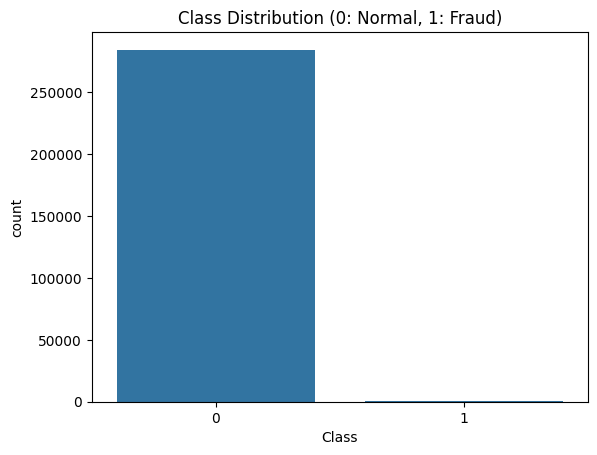

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^

Best Isolation Forest Parameters: {'contamination': 0.001, 'max_samples': 'auto', 'n_estimators': 100}


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: _BaseScorer.__call__() missing 1 required positional argument: 'y_true'

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:960: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 947, in _score
    scores = scorer(estimator, X_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^

Best OCSVM Parameters: {'degree': 2, 'kernel': 'poly', 'nu': 0.01}

Isolation Forest Results:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.39      0.26      0.31        98

    accuracy                           1.00     56962
   macro avg       0.69      0.63      0.65     56962
weighted avg       1.00      1.00      1.00     56962

Confusion Matrix:
 [[56825    39]
 [   73    25]]
ROC AUC: 0.6272080969416466

OCSVM Results:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     56864
           1       0.00      0.01      0.00        98

    accuracy                           0.99     56962
   macro avg       0.50      0.50      0.50     56962
weighted avg       1.00      0.99      0.99     56962

Confusion Matrix:
 [[56159   705]
 [   97     1]]
ROC AUC: 0.4989030396908341


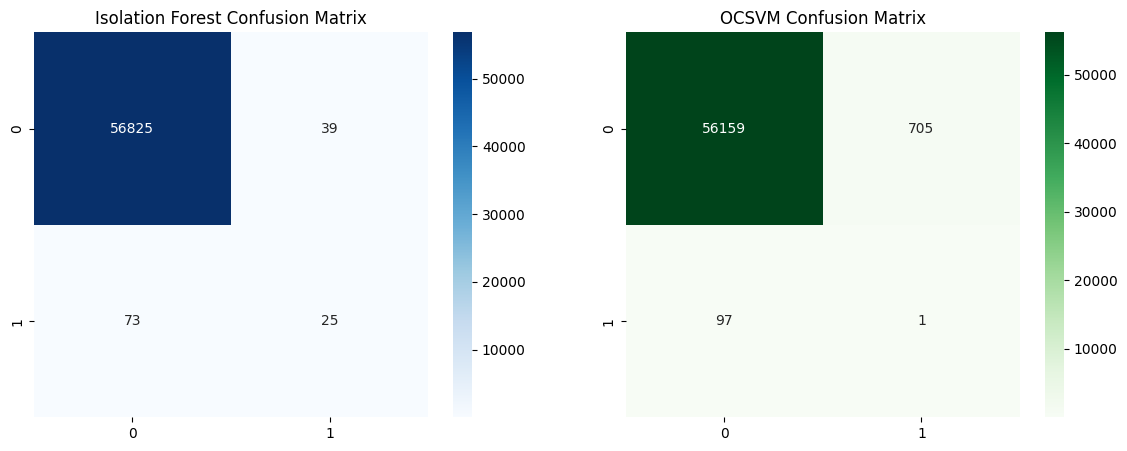

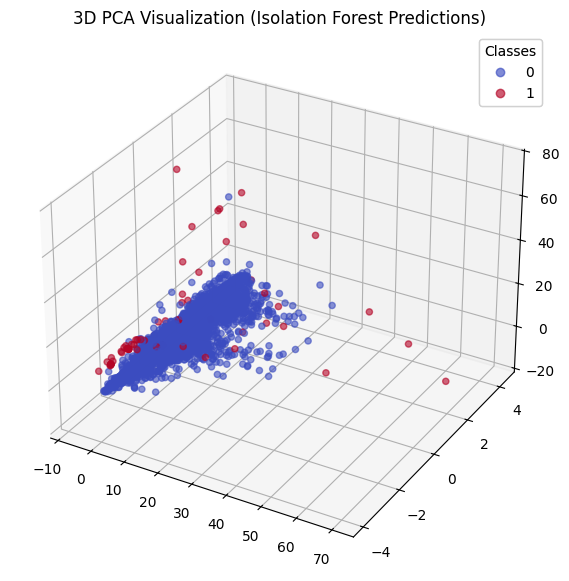

In [ ]:
# 1. Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

# 2. Load the uploaded credit card data
df = pd.read_csv('/content/creditcard.csv')  # adjust path if different

# 3. Perform EDA (Exploratory Data Analysis)
print(df.head())
print(df.info())
print(df['Class'].value_counts())

# Visualize class imbalance
sns.countplot(x='Class', data=df)
plt.title('Class Distribution (0: Normal, 1: Fraud)')
plt.show()

# 4. Split features and target
X = df.drop('Class', axis=1)
y = df['Class']

# 5. Scale the data (important for anomaly detection)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 6. Train-test split (Stratify to maintain class balance)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# 7. Grid Search for Isolation Forest
param_grid_if = {
    'n_estimators': [100, 200],
    'max_samples': ['auto', 0.8],
    'contamination': [0.001, 0.01]
}

grid_if = GridSearchCV(IsolationForest(random_state=42), param_grid_if, cv=3, scoring='f1_weighted')
grid_if.fit(X_train)

print("Best Isolation Forest Parameters:", grid_if.best_params_)

# 8. Grid Search for OCSVM (small subset to avoid slow training)
X_train_small, _, y_train_small, _ = train_test_split(
    X_train, y_train, test_size=0.9, random_state=42, stratify=y_train)

param_grid_ocsvm = {
    'kernel': ['poly'],
    'degree': [2, 3],
    'nu': [0.01, 0.05]
}

# Added scoring='roc_auc' to the GridSearchCV call for OCSVM
grid_ocsvm = GridSearchCV(OneClassSVM(gamma='auto'), param_grid_ocsvm, cv=3, scoring='roc_auc') # Changed here
grid_ocsvm.fit(X_train_small)

print("Best OCSVM Parameters:", grid_ocsvm.best_params_)

# 9. Train best models
model_if = grid_if.best_estimator_
model_ocsvm = grid_ocsvm.best_estimator_

# Predict
y_pred_if = model_if.predict(X_test)
y_pred_ocsvm = model_ocsvm.predict(X_test)

# Convert IF and OCSVM outputs: (-1: outlier, 1: inlier) → (1: Fraud, 0: Normal)
y_pred_if = np.where(y_pred_if == -1, 1, 0)
y_pred_ocsvm = np.where(y_pred_ocsvm == -1, 1, 0)

# 10. Evaluation
print("\nIsolation Forest Results:")
print(classification_report(y_test, y_pred_if))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_if))
print("ROC AUC:", roc_auc_score(y_test, y_pred_if))

print("\nOCSVM Results:")
print(classification_report(y_test, y_pred_ocsvm))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_ocsvm))
print("ROC AUC:", roc_auc_score(y_test, y_pred_ocsvm))

# 11. Confusion Matrix Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_if), annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Isolation Forest Confusion Matrix')

sns.heatmap(confusion_matrix(y_test, y_pred_ocsvm), annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('OCSVM Confusion Matrix')

plt.show()

# 12. PCA for 3D Visualization
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_test)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y_pred_if, cmap='coolwarm', alpha=0.6)
legend = ax.legend(*scatter.legend_elements(), title="Classes")
ax.add_artist(legend)

ax.set_title('3D PCA Visualization (Isolation Forest Predictions)')
plt.show()


Saving creditcard.csv to creditcard (1).csv

--- First 5 Rows of the Data ---
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.00943

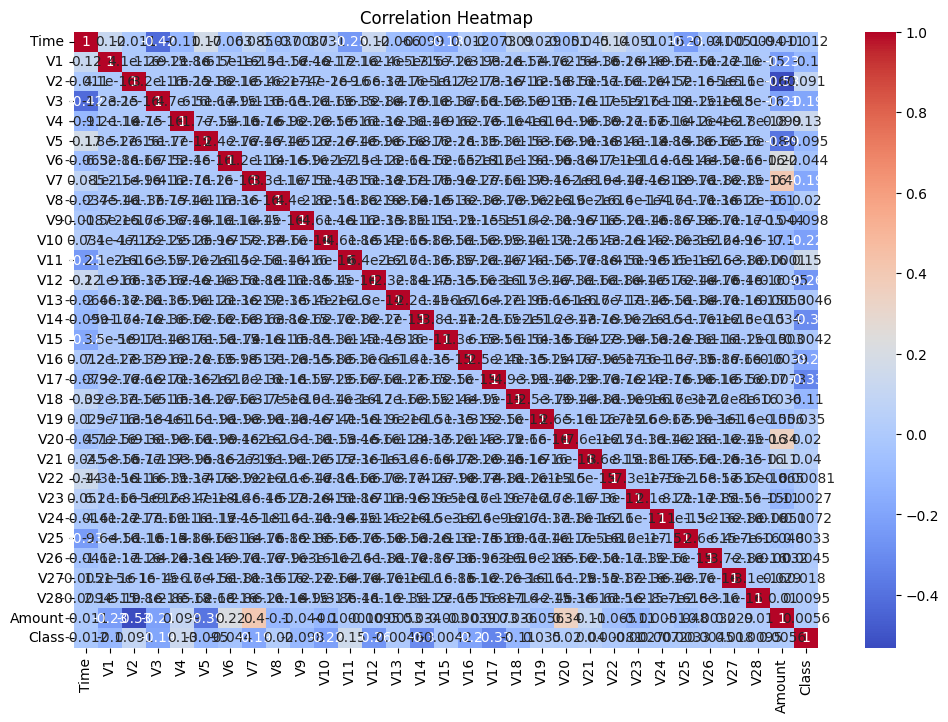


'Target column (Outstate)' not found. Please check the dataset columns.


In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from google.colab import files

# Step 1: Load the file manually
uploaded = files.upload()

# Assuming only one file is uploaded
filename = next(iter(uploaded))

# Read the CSV file
df = pd.read_csv(filename)

# Step 2: Initial Data Exploration
print("\n--- First 5 Rows of the Data ---")
print(df.head())

print("\n--- Data Information ---")
print(df.info())

print("\n--- Data Summary Statistics ---")
print(df.describe())

print("\n--- Checking for Missing Values ---")
print(df.isnull().sum())

# Step 3: Data Cleaning (if necessary)
# For now, drop rows with missing values (optional based on your preference)
df.dropna(inplace=True)

# Step 4: Exploratory Data Analysis (EDA)
# Example: Correlation Heatmap
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Step 5: Visualization Examples
# Scatter plot for a pair of columns if they exist
if 'Outstate' in df.columns and 'F.Undergrad' in df.columns:
    plt.figure(figsize=(8,6))
    sns.scatterplot(data=df, x='F.Undergrad', y='Outstate')
    plt.title('F.Undergrad vs Outstate')
    plt.xlabel('Full-time Undergraduates')
    plt.ylabel('Out-of-State Tuition')
    plt.show()

# Step 6: Prepare Data for Modeling
# Select numeric columns for a basic linear regression
numeric_cols = df.select_dtypes(include='number').columns.tolist()

# Drop 'Unnamed' columns if any
numeric_cols = [col for col in numeric_cols if not col.lower().startswith('unnamed')]

# Pick a target and features
# Example: Predict 'Outstate' based on others
if 'Outstate' in numeric_cols:
    X = df[numeric_cols].drop('Outstate', axis=1)
    y = df['Outstate']

    # Split into training and testing set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Step 7: Train Model
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Step 8: Model Evaluation
    y_pred = model.predict(X_test)

    print("\n--- Model Performance ---")
    print(f"Mean Absolute Error (MAE): {metrics.mean_absolute_error(y_test, y_pred):.2f}")
    print(f"Mean Squared Error (MSE): {metrics.mean_squared_error(y_test, y_pred):.2f}")
    print(f"Root Mean Squared Error (RMSE): {metrics.mean_squared_error(y_test, y_pred, squared=False):.2f}")
    print(f"R² Score: {metrics.r2_score(y_test, y_pred):.2f}")

    # Step 9: Actual vs Predicted Plot
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=y_test, y=y_pred)
    plt.xlabel('Actual Outstate')
    plt.ylabel('Predicted Outstate')
    plt.title('Actual vs Predicted Outstate')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--') # Line for perfect prediction
    plt.show()
else:
    print("\n'Target column (Outstate)' not found. Please check the dataset columns.")



Saving creditcard.csv to creditcard (2).csv

--- First 5 Rows of the Data ---
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.00943

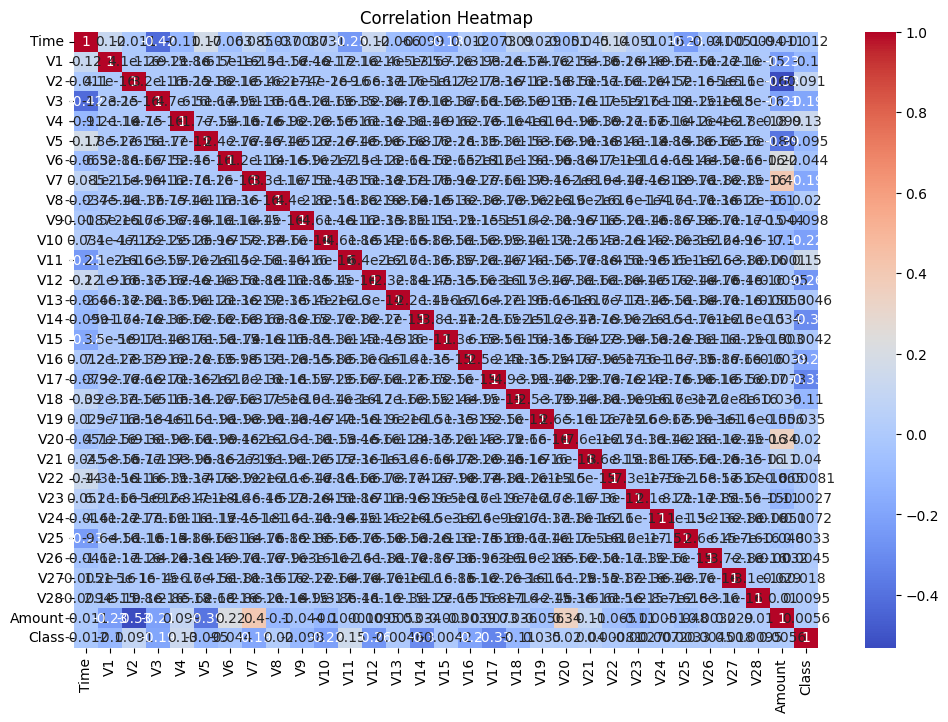


'Target column (Outstate)' not found. Please check the dataset columns.


In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics
from google.colab import files

# Step 1: Load the file manually
uploaded = files.upload()

# Assuming only one file is uploaded
filename = next(iter(uploaded))

# Read the CSV file
df = pd.read_csv(filename)

# Step 2: Initial Data Exploration
print("\n--- First 5 Rows of the Data ---")
print(df.head())

print("\n--- Data Information ---")
print(df.info())

print("\n--- Summary Statistics ---")
print(df.describe())

print("\n--- Missing Values ---")
print(df.isnull().sum())

# Step 3: Data Cleaning
df.dropna(inplace=True)

# Step 4: EDA (Correlation Heatmap)
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Step 5: Visualization (Example: F.Undergrad vs Outstate)
if 'Outstate' in df.columns and 'F.Undergrad' in df.columns:
    plt.figure(figsize=(8,6))
    sns.scatterplot(data=df, x='F.Undergrad', y='Outstate')
    plt.title('F.Undergrad vs Outstate')
    plt.xlabel('Full-time Undergraduates')
    plt.ylabel('Out-of-State Tuition')
    plt.show()

# Step 6: Prepare Data
numeric_cols = df.select_dtypes(include='number').columns.tolist()
numeric_cols = [col for col in numeric_cols if not col.lower().startswith('unnamed')]

# Target and Features
if 'Outstate' in numeric_cols:
    X = df[numeric_cols].drop('Outstate', axis=1)
    y = df['Outstate']

    # Split Data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Step 7: Build a Pipeline with StandardScaler and LinearRegression
    pipeline = Pipeline([
        ('scaler', StandardScaler()),     # Standardize features
        ('regressor', LinearRegression()) # Linear Regression Model
    ])

    # Step 8: Train the pipeline
    pipeline.fit(X_train, y_train)

    # Step 9: Make Predictions
    y_pred = pipeline.predict(X_test)

    # Step 10: Evaluation
    print("\n--- Model Performance with Pipeline ---")
    print(f"Mean Absolute Error (MAE): {metrics.mean_absolute_error(y_test, y_pred):.2f}")
    print(f"Mean Squared Error (MSE): {metrics.mean_squared_error(y_test, y_pred):.2f}")
    print(f"Root Mean Squared Error (RMSE): {metrics.mean_squared_error(y_test, y_pred, squared=False):.2f}")
    print(f"R² Score: {metrics.r2_score(y_test, y_pred):.2f}")

    # Step 11: Actual vs Predicted Plot
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=y_test, y=y_pred)
    plt.xlabel('Actual Outstate')
    plt.ylabel('Predicted Outstate')
    plt.title('Actual vs Predicted Outstate')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.show()
else:
    print("\n'Target column (Outstate)' not found. Please check the dataset columns.")



Saving creditcard.csv to creditcard (3).csv

--- First 5 Rows of the Data ---
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.00943

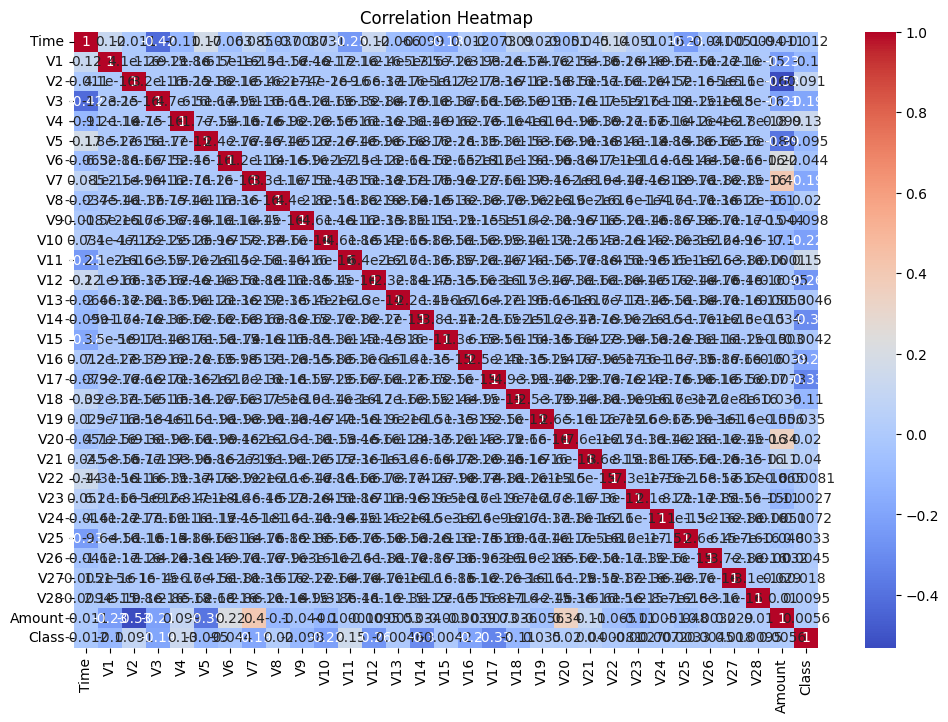


'Target column (Outstate)' not found. Please check the dataset columns.


In [ ]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics
from google.colab import files

# Set global random seed
RANDOM_STATE = 42

# Step 1: Load the file manually
uploaded = files.upload()

# Assuming only one file is uploaded
filename = next(iter(uploaded))

# Read the CSV file
df = pd.read_csv(filename)

# Step 2: Initial Data Exploration
print("\n--- First 5 Rows of the Data ---")
print(df.head())

print("\n--- Data Information ---")
df.info()

print("\n--- Summary Statistics ---")
print(df.describe())

print("\n--- Missing Values ---")
print(df.isnull().sum())

# Step 3: Data Cleaning
df.dropna(inplace=True)

# Step 4: EDA (Correlation Heatmap)
correlation_matrix = df.corr(numeric_only=True)  # Compute once
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# Step 5: Visualization (Example: F.Undergrad vs Outstate)
if {'Outstate', 'F.Undergrad'}.issubset(df.columns):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x='F.Undergrad', y='Outstate')
    plt.title('F.Undergrad vs Outstate')
    plt.xlabel('Full-time Undergraduates')
    plt.ylabel('Out-of-State Tuition')
    plt.show()

# Step 6: Prepare Data
numeric_cols = df.select_dtypes(include='number').columns
numeric_cols = [col for col in numeric_cols if not col.lower().startswith('unnamed')]

# Target and Features
if 'Outstate' in numeric_cols:
    X = df[numeric_cols].drop('Outstate', axis=1)
    y = df['Outstate']

    # Split Data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

    # Step 7: Build a Pipeline with StandardScaler and LinearRegression
    pipeline = Pipeline([
        ('scaler', StandardScaler()),     # Standardize features
        ('regressor', LinearRegression()) # Linear Regression Model
    ])

    # Step 8: Train the pipeline
    pipeline.fit(X_train, y_train)

    # Step 9: Make Predictions
    y_pred = pipeline.predict(X_test)

    # Step 10: Evaluation
    print("\n--- Model Performance with Pipeline ---")
    print(f"Mean Absolute Error (MAE): {metrics.mean_absolute_error(y_test, y_pred):.2f}")
    print(f"Mean Squared Error (MSE): {metrics.mean_squared_error(y_test, y_pred):.2f}")
    print(f"Root Mean Squared Error (RMSE): {metrics.mean_squared_error(y_test, y_pred, squared=False):.2f}")
    print(f"R² Score: {metrics.r2_score(y_test, y_pred):.2f}")

    # Step 11: Actual vs Predicted Plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test, y=y_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal Fit')
    plt.xlabel('Actual Outstate')
    plt.ylabel('Predicted Outstate')
    plt.title('Actual vs Predicted Outstate')
    plt.legend()
    plt.show()
else:
    print("\n'Target column (Outstate)' not found. Please check the dataset columns.")


In [12]:
# Install LazyPredict (only need to do this once)
!pip install lazypredict

# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyRegressor
from google.colab import files

# Set global random seed
RANDOM_STATE = 42

# Step 1: Load the file manually
uploaded = files.upload()

# Assuming only one file is uploaded
filename = next(iter(uploaded))

# Read the CSV file
df = pd.read_csv(filename)

# Step 2: Initial Data Exploration
print("\n--- First 5 Rows of the Data ---")
print(df.head())

print("\n--- Data Information ---")
df.info()

print("\n--- Summary Statistics ---")
print(df.describe())

print("\n--- Missing Values ---")
print(df.isnull().sum())

# Step 3: Data Cleaning
df.dropna(inplace=True)

# Step 4: Prepare Data
numeric_cols = df.select_dtypes(include='number').columns
numeric_cols = [col for col in numeric_cols if not col.lower().startswith('unnamed')]

# Target and Features
if 'Outstate' in numeric_cols:
    X = df[numeric_cols].drop('Outstate', axis=1)
    y = df['Outstate']

    # Split Data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

    # Step 5: LazyPredict (Quick Model Benchmarking)
    reg = LazyRegressor(verbose=0, ignore_warnings=True, random_state=RANDOM_STATE)
    models, predictions = reg.fit(X_train, X_test, y_train, y_test)

    print("\n--- LazyPredict Model Comparison ---")
    print(models)
else:
    print("\n'Target column (Outstate)' not found. Please check the dataset columns.")


KeyboardInterrupt: 

Saving creditcard.csv to creditcard (5).csv

--- First 5 Rows of the Data ---
   Time    V1    V2   V3    V4    V5    V6    V7    V8    V9  ...   V21   V22  \
0  0.00 -1.36 -0.07 2.54  1.38 -0.34  0.46  0.24  0.10  0.36  ... -0.02  0.28   
1  0.00  1.19  0.27 0.17  0.45  0.06 -0.08 -0.08  0.09 -0.26  ... -0.23 -0.64   
2  1.00 -1.36 -1.34 1.77  0.38 -0.50  1.80  0.79  0.25 -1.51  ...  0.25  0.77   
3  1.00 -0.97 -0.19 1.79 -0.86 -0.01  1.25  0.24  0.38 -1.39  ... -0.11  0.01   
4  2.00 -1.16  0.88 1.55  0.40 -0.41  0.10  0.59 -0.27  0.82  ... -0.01  0.80   

    V23   V24   V25   V26   V27   V28  Amount  Class  
0 -0.11  0.07  0.13 -0.19  0.13 -0.02  149.62      0  
1  0.10 -0.34  0.17  0.13 -0.01  0.01    2.69      0  
2  0.91 -0.69 -0.33 -0.14 -0.06 -0.06  378.66      0  
3 -0.19 -1.18  0.65 -0.22  0.06  0.06  123.50      0  
4 -0.14  0.14 -0.21  0.50  0.22  0.22   69.99      0  

[5 rows x 31 columns]

--- Data Information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807

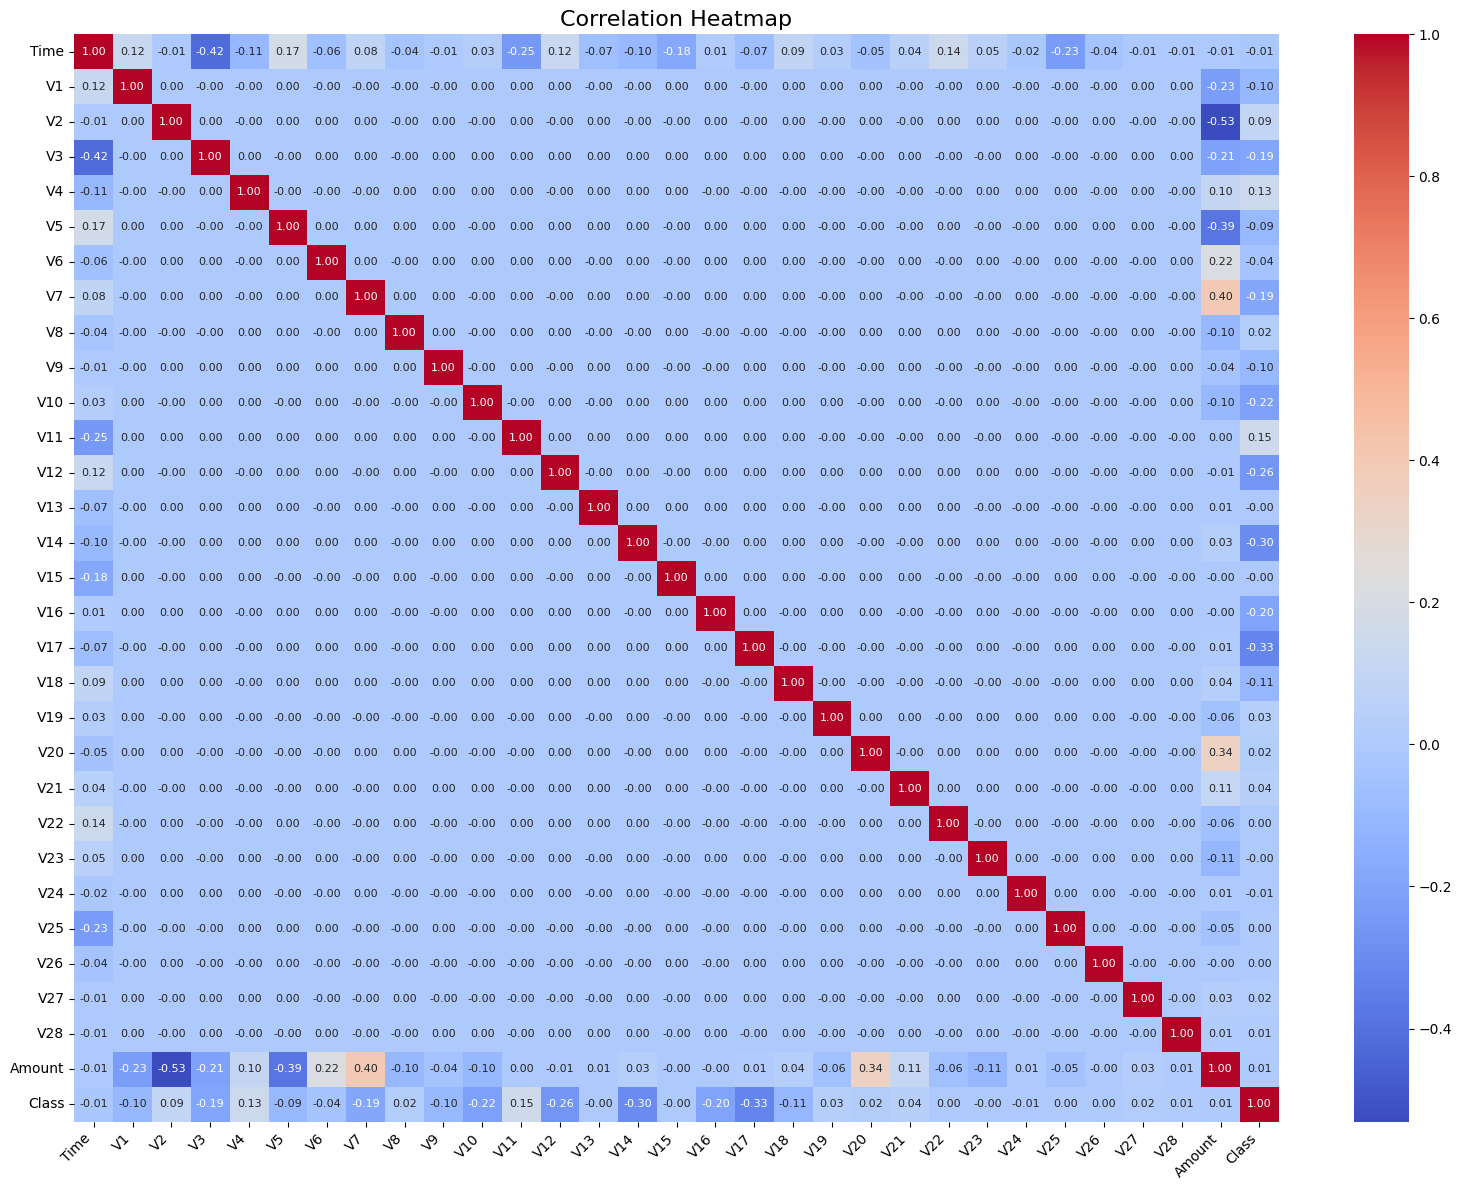


'Target column (Outstate)' not found. Please check the dataset columns.


In [13]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics
from google.colab import files

# Set global random seed
RANDOM_STATE = 42

# Step 1: Load the file manually
uploaded = files.upload()

# Assuming only one file is uploaded
filename = next(iter(uploaded))

# Read the CSV file
df = pd.read_csv(filename)

# Step 2: Initial Data Exploration
print("\n--- First 5 Rows of the Data ---")
print(df.head())

print("\n--- Data Information ---")
df.info()

print("\n--- Summary Statistics ---")
print(df.describe())

print("\n--- Missing Values ---")
print(df.isnull().sum())

# Step 3: Data Cleaning
df.dropna(inplace=True)

# Step 4: EDA (Correlation Heatmap)
correlation_matrix = df.corr(numeric_only=True)  # Compute once
plt.figure(figsize=(16, 12))  # Increase the figure size
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={"size": 8})

# Rotate the x and y-axis labels
plt.xticks(rotation=45, ha='right')  # Rotate x labels
plt.yticks(rotation=0)                # Keep y labels horizontal

plt.title('Correlation Heatmap', fontsize=16)
plt.tight_layout()  # Adjust layout to prevent label cut-off
plt.show()

# Step 5: Visualization (Example: F.Undergrad vs Outstate)
if {'Outstate', 'F.Undergrad'}.issubset(df.columns):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x='F.Undergrad', y='Outstate')
    plt.title('F.Undergrad vs Outstate')
    plt.xlabel('Full-time Undergraduates')
    plt.ylabel('Out-of-State Tuition')
    plt.show()

# Step 6: Prepare Data
numeric_cols = df.select_dtypes(include='number').columns
numeric_cols = [col for col in numeric_cols if not col.lower().startswith('unnamed')]

# Target and Features
if 'Outstate' in numeric_cols:
    X = df[numeric_cols].drop('Outstate', axis=1)
    y = df['Outstate']

    # Split Data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

    # Step 7: Build a Pipeline with StandardScaler and LinearRegression
    pipeline = Pipeline([
        ('scaler', StandardScaler()),     # Standardize features
        ('regressor', LinearRegression()) # Linear Regression Model
    ])

    # Step 8: Train the pipeline
    pipeline.fit(X_train, y_train)

    # Step 9: Make Predictions
    y_pred = pipeline.predict(X_test)

    # Step 10: Evaluation
    print("\n--- Model Performance with Pipeline ---")
    print(f"Mean Absolute Error (MAE): {metrics.mean_absolute_error(y_test, y_pred):.2f}")
    print(f"Mean Squared Error (MSE): {metrics.mean_squared_error(y_test, y_pred):.2f}")
    print(f"Root Mean Squared Error (RMSE): {metrics.mean_squared_error(y_test, y_pred, squared=False):.2f}")
    print(f"R² Score: {metrics.r2_score(y_test, y_pred):.2f}")

    # Step 11: Actual vs Predicted Plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test, y=y_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal Fit')
    plt.xlabel('Actual Outstate')
    plt.ylabel('Predicted Outstate')
    plt.title('Actual vs Predicted Outstate')
    plt.legend()
    plt.show()
else:
    print("\n'Target column (Outstate)' not found. Please check the dataset columns.")



--- First 5 Rows of the Data ---
   Time    V1    V2   V3    V4    V5    V6    V7    V8    V9  ...   V21   V22  \
0  0.00 -1.36 -0.07 2.54  1.38 -0.34  0.46  0.24  0.10  0.36  ... -0.02  0.28   
1  0.00  1.19  0.27 0.17  0.45  0.06 -0.08 -0.08  0.09 -0.26  ... -0.23 -0.64   
2  1.00 -1.36 -1.34 1.77  0.38 -0.50  1.80  0.79  0.25 -1.51  ...  0.25  0.77   
3  1.00 -0.97 -0.19 1.79 -0.86 -0.01  1.25  0.24  0.38 -1.39  ... -0.11  0.01   
4  2.00 -1.16  0.88 1.55  0.40 -0.41  0.10  0.59 -0.27  0.82  ... -0.01  0.80   

    V23   V24   V25   V26   V27   V28  Amount  Class  
0 -0.11  0.07  0.13 -0.19  0.13 -0.02  149.62      0  
1  0.10 -0.34  0.17  0.13 -0.01  0.01    2.69      0  
2  0.91 -0.69 -0.33 -0.14 -0.06 -0.06  378.66      0  
3 -0.19 -1.18  0.65 -0.22  0.06  0.06  123.50      0  
4 -0.14  0.14 -0.21  0.50  0.22  0.22   69.99      0  

[5 rows x 31 columns]

--- Data Information ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31

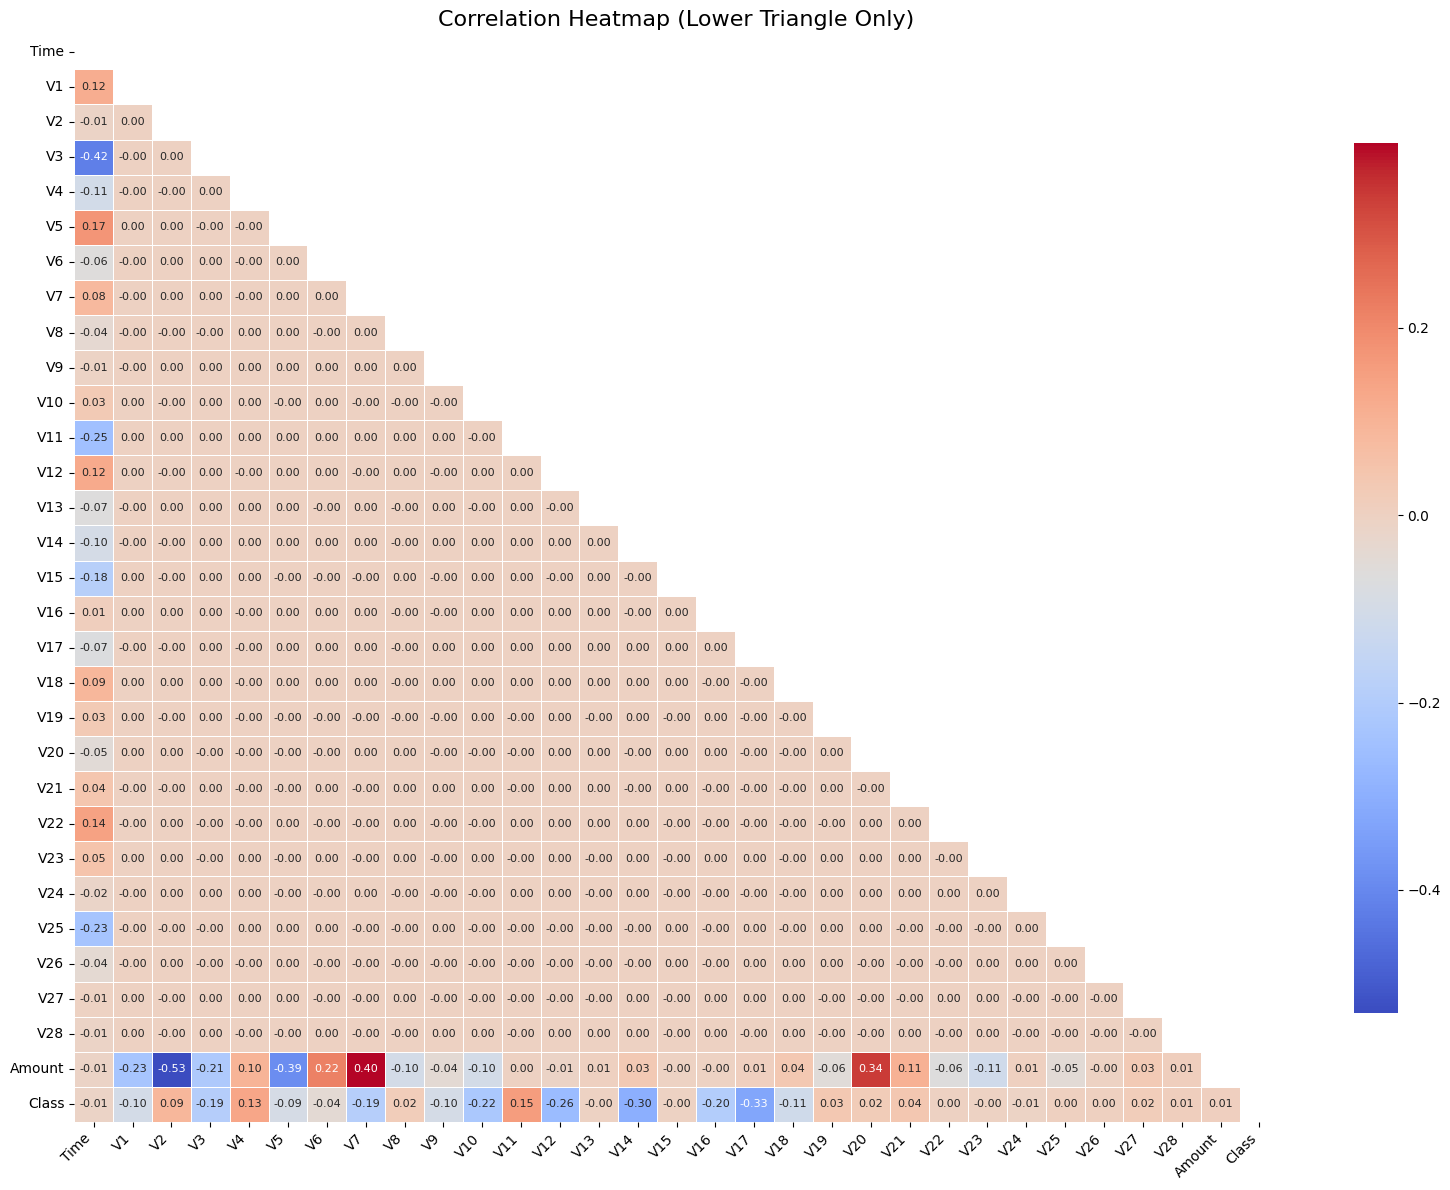


'Target column (Outstate)' not found. Please check the dataset columns.


In [14]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics
from google.colab import files

# Set global random seed
RANDOM_STATE = 42

# Step 1: Load the file manually
#uploaded = files.upload()

# Assuming only one file is uploaded
#filename = next(iter(uploaded))

# Read the CSV file
#df = pd.read_csv(filename)

# Step 2: Initial Data Exploration
print("\n--- First 5 Rows of the Data ---")
print(df.head())

print("\n--- Data Information ---")
df.info()

print("\n--- Summary Statistics ---")
print(df.describe())

print("\n--- Missing Values ---")
print(df.isnull().sum())

# Step 3: Data Cleaning
df.dropna(inplace=True)

# Step 4: EDA (Super-Polished Correlation Heatmap)
correlation_matrix = df.corr(numeric_only=True)

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(16, 12))

# Draw the heatmap
sns.heatmap(
    correlation_matrix,
    mask=mask,
    cmap='coolwarm',
    annot=True,
    fmt='.2f',
    annot_kws={"size":8},
    linewidths=0.5,   # Adds space between boxes
    cbar_kws={"shrink": 0.8}  # Shrink colorbar size
)

# Rotate the labels
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.title('Correlation Heatmap (Lower Triangle Only)', fontsize=16)
plt.tight_layout()
plt.show()


# Step 5: Visualization (Example: F.Undergrad vs Outstate)
if {'Outstate', 'F.Undergrad'}.issubset(df.columns):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x='F.Undergrad', y='Outstate')
    plt.title('F.Undergrad vs Outstate')
    plt.xlabel('Full-time Undergraduates')
    plt.ylabel('Out-of-State Tuition')
    plt.show()

# Step 6: Prepare Data
numeric_cols = df.select_dtypes(include='number').columns
numeric_cols = [col for col in numeric_cols if not col.lower().startswith('unnamed')]

# Target and Features
if 'Outstate' in numeric_cols:
    X = df[numeric_cols].drop('Outstate', axis=1)
    y = df['Outstate']

    # Split Data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=RANDOM_STATE)

    # Step 7: Build a Pipeline with StandardScaler and LinearRegression
    pipeline = Pipeline([
        ('scaler', StandardScaler()),     # Standardize features
        ('regressor', LinearRegression()) # Linear Regression Model
    ])

    # Step 8: Train the pipeline
    pipeline.fit(X_train, y_train)

    # Step 9: Make Predictions
    y_pred = pipeline.predict(X_test)

    # Step 10: Evaluation
    print("\n--- Model Performance with Pipeline ---")
    print(f"Mean Absolute Error (MAE): {metrics.mean_absolute_error(y_test, y_pred):.2f}")
    print(f"Mean Squared Error (MSE): {metrics.mean_squared_error(y_test, y_pred):.2f}")
    print(f"Root Mean Squared Error (RMSE): {metrics.mean_squared_error(y_test, y_pred, squared=False):.2f}")
    print(f"R² Score: {metrics.r2_score(y_test, y_pred):.2f}")

    # Step 11: Actual vs Predicted Plot
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test, y=y_pred)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Ideal Fit')
    plt.xlabel('Actual Outstate')
    plt.ylabel('Predicted Outstate')
    plt.title('Actual vs Predicted Outstate')
    plt.legend()
    plt.show()
else:
    print("\n'Target column (Outstate)' not found. Please check the dataset columns.")